### RL - linear function approximation with random fourier features workflow
In this document I'd like to show what's the problem in my code and clean my thoughts. The environment is CartPole-v1


#### use Q learning with RFFs to learn a good policy
The following is a codebase which use DQN to learn a good policy.

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v0")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
torch.cuda.is_available()

c:\Users\xuanf\miniconda3\envs\policy-eval\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


True

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def policy_DQN(state):
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    return policy_net(state).max(1).indices.view(1, 1)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values #in dqn they use target_net
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    # criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
num_episodes = 10
print("test the performance for policy:")

for i_episode in range(num_episodes):
    state, _ = env.reset()
    for t in range(1, 10000):
        action = policy_DQN(state)
        state, reward, terminated, truncated, _ = env.step(action.item())
        if terminated or truncated:
            print(f"DQN policy: Episode {i_episode + 1} finished after {t} timesteps")
            break

test the performance for policy:
DQN policy: Episode 1 finished after 350 timesteps
DQN policy: Episode 2 finished after 352 timesteps
DQN policy: Episode 3 finished after 330 timesteps
DQN policy: Episode 4 finished after 383 timesteps
DQN policy: Episode 5 finished after 500 timesteps
DQN policy: Episode 6 finished after 333 timesteps
DQN policy: Episode 7 finished after 500 timesteps
DQN policy: Episode 8 finished after 365 timesteps
DQN policy: Episode 9 finished after 500 timesteps
DQN policy: Episode 10 finished after 359 timesteps


First I tried to replace change DQNNet with RBFNet  (linear with random fourier features), the convergence is very slow, at that time I give up using RFFs.

Complete


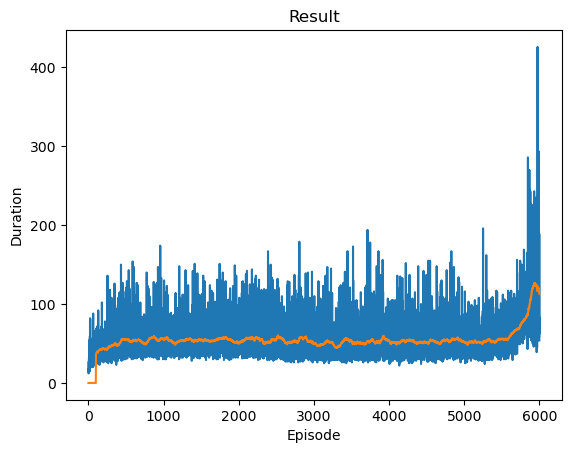

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.kernel_approximation import RBFSampler
class RBFNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.n_components = 256
        self.linear = nn.Linear(self.n_components, output_size)
        self.rbf_feature = RBFSampler(gamma=1, random_state=1, n_components=self.n_components)
        self.device = device
        
    def forward(self, x):
        # Convert to numpy and ensure 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add batch dimension if single sample
        x_np = x.cpu().numpy()
        
        # Transform features
        feature_np = self.rbf_feature.fit_transform(x_np)
        feature = torch.tensor(feature_np, dtype=torch.float).to(self.device)
        output = self.linear(feature)
        return output
        
    def init(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net_linear = RBFNet(n_observations, n_actions).to(device)
target_net_linear = RBFNet(n_observations, n_actions).to(device)
target_net_linear.load_state_dict(policy_net_linear.state_dict())

optimizer = optim.AdamW(policy_net_linear.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net_linear(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def policy_linear(state):
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    return policy_net_linear(state).max(1).indices.view(1, 1)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net_linear(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net_linear(non_final_next_states).max(1).values #in dqn they use target_net
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    # criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net_linear.parameters(), 100)
    optimizer.step()
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 6000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net_linear.state_dict()
        policy_net_state_dict = policy_net_linear.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net_linear.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
num_episodes = 10
print("test the performance for policy:")

for i_episode in range(num_episodes):
    state, _ = env.reset()
    for t in range(1, 10000):
        action = policy_linear(state)
        state, reward, terminated, truncated, _ = env.step(action.item())
        if terminated or truncated:
            print(f"DQN policy: Episode {i_episode + 1} finished after {t} timesteps")
            break

test the performance for policy:
DQN policy: Episode 1 finished after 92 timesteps
DQN policy: Episode 2 finished after 92 timesteps
DQN policy: Episode 3 finished after 61 timesteps
DQN policy: Episode 4 finished after 106 timesteps
DQN policy: Episode 5 finished after 84 timesteps
DQN policy: Episode 6 finished after 56 timesteps
DQN policy: Episode 7 finished after 155 timesteps
DQN policy: Episode 8 finished after 49 timesteps
DQN policy: Episode 9 finished after 126 timesteps
DQN policy: Episode 10 finished after 106 timesteps


But using this code from you I can make things very fast and the results are good.

c:\Users\xuanf\miniconda3\envs\policy-eval\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


cuda

Run 1/1
Training MLP Network...


  0%|          | 5/2000 [00:00<00:50, 39.65it/s]

Episode 0, Average Score: 23.00


  5%|▌         | 101/2000 [00:18<14:21,  2.20it/s]

Episode 100, Average Score: 64.89


 10%|█         | 201/2000 [01:04<15:47,  1.90it/s]

Episode 200, Average Score: 176.71


 15%|█▌        | 301/2000 [01:54<16:39,  1.70it/s]

Episode 300, Average Score: 186.22


 20%|██        | 401/2000 [02:50<15:00,  1.78it/s]

Episode 400, Average Score: 195.15


 25%|██▌       | 503/2000 [03:43<04:28,  5.57it/s]

Episode 500, Average Score: 190.83


 30%|███       | 601/2000 [04:33<11:15,  2.07it/s]

Episode 600, Average Score: 192.90


 35%|███▌      | 701/2000 [05:22<10:22,  2.09it/s]

Episode 700, Average Score: 197.92


 40%|████      | 801/2000 [06:10<10:04,  1.98it/s]

Episode 800, Average Score: 199.81


 45%|████▌     | 901/2000 [06:56<08:41,  2.11it/s]

Episode 900, Average Score: 195.98


 50%|█████     | 1001/2000 [07:41<06:53,  2.42it/s]

Episode 1000, Average Score: 199.11


 55%|█████▌    | 1101/2000 [08:24<06:09,  2.43it/s]

Episode 1100, Average Score: 188.68


 60%|██████    | 1201/2000 [09:07<05:25,  2.45it/s]

Episode 1200, Average Score: 189.56


 65%|██████▌   | 1301/2000 [09:52<05:25,  2.15it/s]

Episode 1300, Average Score: 196.97


 70%|███████   | 1401/2000 [10:39<03:18,  3.02it/s]

Episode 1400, Average Score: 195.79


 75%|███████▌  | 1501/2000 [11:21<04:12,  1.98it/s]

Episode 1500, Average Score: 173.52


 80%|████████  | 1601/2000 [12:08<03:37,  1.83it/s]

Episode 1600, Average Score: 191.59


 85%|████████▌ | 1701/2000 [12:54<02:14,  2.22it/s]

Episode 1700, Average Score: 194.50


 90%|█████████ | 1801/2000 [13:41<01:38,  2.01it/s]

Episode 1800, Average Score: 178.96


 95%|█████████▌| 1901/2000 [14:30<00:49,  2.02it/s]

Episode 1900, Average Score: 188.34


100%|██████████| 2000/2000 [15:11<00:00,  2.20it/s]


Training RBF Network...


  0%|          | 6/2000 [00:00<01:00, 32.93it/s]

Episode 0, Average Score: 22.00


  5%|▌         | 102/2000 [00:12<04:07,  7.67it/s]

Episode 100, Average Score: 25.73


 10%|█         | 201/2000 [00:44<26:13,  1.14it/s]

Episode 200, Average Score: 73.01


 15%|█▌        | 301/2000 [02:13<24:41,  1.15it/s]

Episode 300, Average Score: 196.33


 20%|██        | 401/2000 [03:33<17:27,  1.53it/s]

Episode 400, Average Score: 172.77


 25%|██▌       | 501/2000 [04:21<13:28,  1.85it/s]

Episode 500, Average Score: 104.71


 30%|███       | 601/2000 [05:35<20:15,  1.15it/s]

Episode 600, Average Score: 163.40


 35%|███▌      | 701/2000 [07:05<18:21,  1.18it/s]

Episode 700, Average Score: 193.44


 40%|████      | 801/2000 [08:30<16:54,  1.18it/s]

Episode 800, Average Score: 187.20


 45%|████▌     | 901/2000 [09:55<14:59,  1.22it/s]

Episode 900, Average Score: 183.93


 50%|█████     | 1001/2000 [11:21<14:30,  1.15it/s]

Episode 1000, Average Score: 184.07


 55%|█████▌    | 1101/2000 [12:47<12:55,  1.16it/s]

Episode 1100, Average Score: 185.02


 60%|██████    | 1201/2000 [14:22<11:26,  1.16it/s]

Episode 1200, Average Score: 189.40


 65%|██████▌   | 1301/2000 [15:59<11:18,  1.03it/s]

Episode 1300, Average Score: 195.74


 70%|███████   | 1401/2000 [17:30<08:35,  1.16it/s]

Episode 1400, Average Score: 185.16


 75%|███████▌  | 1501/2000 [19:02<08:04,  1.03it/s]

Episode 1500, Average Score: 187.47


 80%|████████  | 1601/2000 [20:35<06:32,  1.02it/s]

Episode 1600, Average Score: 179.67


 85%|████████▌ | 1701/2000 [22:07<04:33,  1.09it/s]

Episode 1700, Average Score: 181.49


 90%|█████████ | 1801/2000 [23:45<03:19,  1.00s/it]

Episode 1800, Average Score: 197.62


 95%|█████████▌| 1901/2000 [25:11<01:11,  1.38it/s]

Episode 1900, Average Score: 185.04


100%|██████████| 2000/2000 [26:33<00:00,  1.26it/s]


Final Performance Statistics:
MLP Final Average Score: 169.21 ± 0.00
RBF Final Average Score: 196.91 ± 0.00


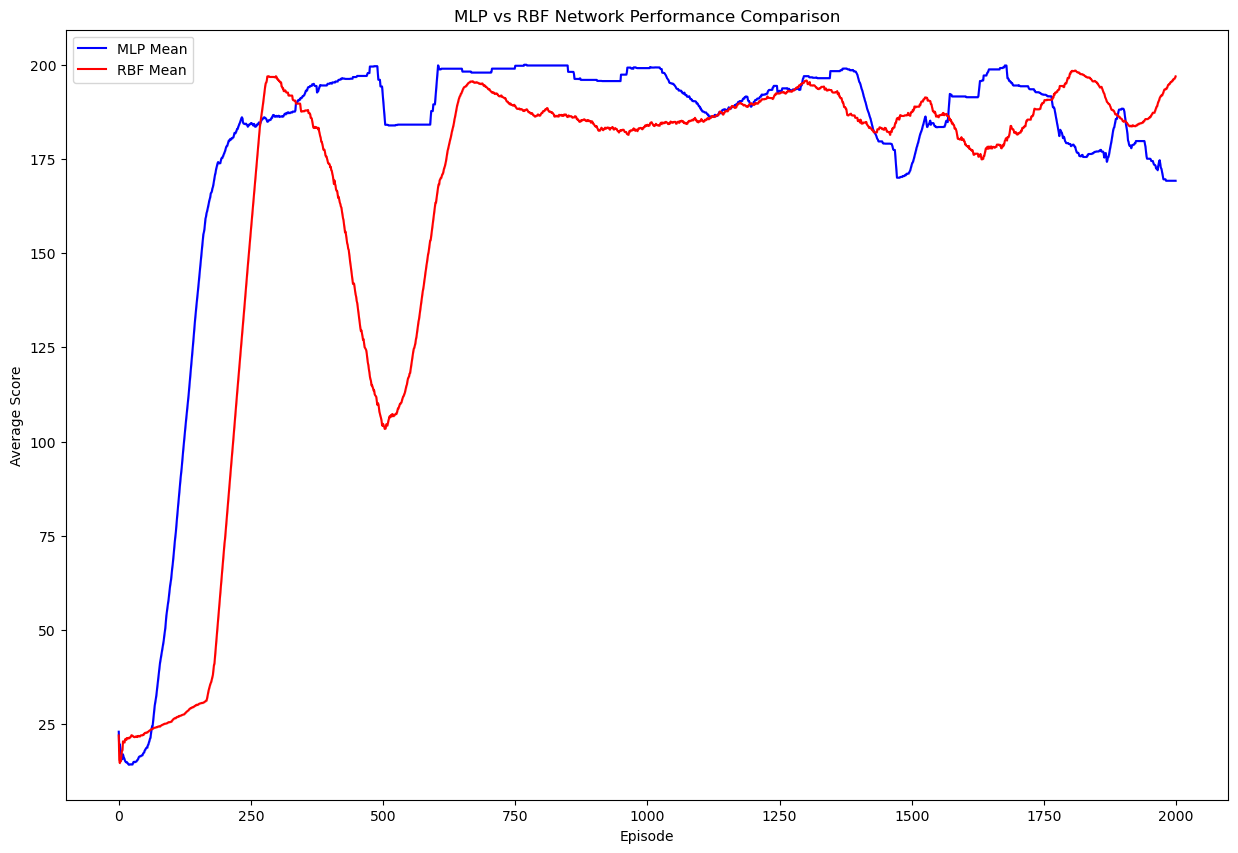

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

print(device)

from sklearn.kernel_approximation import RBFSampler

X = np.array([[0, 1, 1]])

# print(X.shape)

rbf_feature = RBFSampler(gamma=1, random_state=1, n_components=100)
X_features = rbf_feature.fit_transform(X)

# print(X_features)

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.device = device
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    def init(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
#                 nn.init.zeros_(layer.weight)


class RBFNet(nn.Module):
    def __init__(self, input_size, output_size, device):
        super().__init__()
        self.n_components = 500
        self.linear = nn.Linear(self.n_components, output_size)
        self.rbf_feature = RBFSampler(gamma=1, random_state=1, n_components=self.n_components)
        self.device = device
        
    def forward(self, x):
        # Convert to numpy and ensure 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Add batch dimension if single sample
        x_np = x.cpu().numpy()
        
        # Transform features
        feature_np = self.rbf_feature.fit_transform(x_np)
        feature = torch.tensor(feature_np, dtype=torch.float).to(self.device)
        output = self.linear(feature)
        
        # If input was single sample, squeeze output
        if x_np.shape[0] == 1:
            output = output.squeeze(0)
            
        return output
        
    def init(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
#                 nn.init.zeros_(layer.weight)

class DQN_Agent(object):
    def __init__(self, **kwargs):
        self.gamma = kwargs['gamma']
        self.epsi_high = kwargs['epsi_high'] 
        self.epsi_low = kwargs['epsi_low']
        self.decay = kwargs['decay']
        self.lr = kwargs['lr']
        self.buffer = []  # Replay buffer
        self.capacity = kwargs['capacity']
        self.batch_size = kwargs['batch_size']
        self.state_space_dim = kwargs['state_space_dim']
        self.action_space_dim = kwargs['action_space_dim']
        self.device = kwargs['device']
        self.network_type = kwargs['network_type']  # 'mlp' or 'rbf'

        # Initialize networks based on type
        if self.network_type == 'mlp':
            self.q_net = Net(self.state_space_dim, 256, self.action_space_dim, self.device).to(self.device)
            self.target_net = Net(self.state_space_dim, 256, self.action_space_dim, self.device).to(self.device)
        else:  # rbf
            self.q_net = RBFNet(self.state_space_dim, self.action_space_dim, self.device).to(self.device)
            self.target_net = RBFNet(self.state_space_dim, self.action_space_dim, self.device).to(self.device)
        
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.steps = 0
        self.update_target_steps = 100

    def act(self, s0):
        self.steps += 1
        epsi = self.epsi_low + (self.epsi_high-self.epsi_low) * (math.exp(-1.0 * self.steps/self.decay))
        if random.random() < epsi:
            return random.randrange(self.action_space_dim)
        else:
            with torch.no_grad():
                s0 = s0[0] if isinstance(s0, tuple) else s0
                state = torch.tensor(s0, dtype=torch.float).to(self.device)
                q_values = self.q_net(state)
                return torch.argmax(q_values).item()

    def put(self, *transition):
        if len(self.buffer) == self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)

    def learn(self):
        if len(self.buffer) < self.batch_size:
            return
        
        # Sample random batch from replay buffer
        samples = random.sample(self.buffer, self.batch_size)
        s0, a0, r1, s1, done = zip(*samples)
        # s0 = s0[0] if isinstance(s0, tuple) else s0
        # Convert to tensors
        s0 = [s[0] if isinstance(s, tuple) else s for s in s0]
        s1 = [s[0] if isinstance(s, tuple) else s for s in s1]
        s0 = torch.tensor(s0, dtype=torch.float).to(self.device)
        a0 = torch.tensor(a0, dtype=torch.long).view(self.batch_size, -1).to(self.device)
        r1 = torch.tensor(r1, dtype=torch.float).view(self.batch_size, -1).to(self.device)
        s1 = torch.tensor(s1, dtype=torch.float).to(self.device)
        done = torch.tensor(done, dtype=torch.float).view(self.batch_size, -1).to(self.device)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(s1)
            a = torch.max(next_q_values)
            max_next_q = torch.max(next_q_values, dim=1)[0].view(self.batch_size, -1)
            target_q = r1 + (1 - done) * self.gamma * max_next_q

        # Compute current Q values
        current_q = self.q_net(s0).gather(1, a0)

        # Compute loss and update
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        if self.steps % self.update_target_steps == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

# Main training loop
def train_dqn(env, agent, num_episodes):
    scores = []
    mean_scores = []
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated,  _ = env.step(action)
            done = terminated or truncated
            # Store transition in replay buffer
            agent.put(state, action, reward, next_state, done)
            
            # Train the network
            agent.learn()
            
            total_reward += reward
            state = next_state
            
        scores.append(total_reward)
        mean_scores.append(np.mean(scores[-100:]))  # Moving average of last 100 episodes
        
        if episode % 100 == 0:
            print(f'Episode {episode}, Average Score: {mean_scores[-1]:.2f}')
    
    return scores, mean_scores

def compare_networks(env, num_episodes=500, num_runs=5):
    params = {
        'gamma': 0.99,
        'epsi_high': 0.9,
        'epsi_low': 0.05,
        'decay': 200,
        'lr': 0.001,
        'capacity': 10000,
        'batch_size': 64,
        'state_space_dim': env.observation_space.shape[0],
        'action_space_dim': env.action_space.n,
        'device': device
    }
    
    mlp_results = []
    rbf_results = []
    
    # Run multiple times for statistical significance
    for run in range(num_runs):
        print(f"\nRun {run + 1}/{num_runs}")
        
        # Train MLP
        print("Training MLP Network...")
        params['network_type'] = 'mlp'
        mlp_agent = DQN_Agent(**params)
        mlp_scores, mlp_means = train_dqn(env, mlp_agent, num_episodes)
        mlp_results.append(mlp_means)
        
        # Train RBF
        print("Training RBF Network...")
        params['network_type'] = 'rbf'
        rbf_agent = DQN_Agent(**params)
        rbf_scores, rbf_means = train_dqn(env, rbf_agent, num_episodes)
        rbf_results.append(rbf_means)
    
    # Plot results
    plt.figure(figsize=(15,10))
    
    # Plot MLP results
    mlp_mean = np.mean(mlp_results, axis=0)
    mlp_std = np.std(mlp_results, axis=0)
    plt.plot(mlp_mean, label='MLP Mean', color='blue')
    plt.fill_between(range(len(mlp_mean)), 
                    mlp_mean - mlp_std, 
                    mlp_mean + mlp_std, 
                    alpha=0.2, 
                    color='blue')
    
    # Plot RBF results
    rbf_mean = np.mean(rbf_results, axis=0)
    rbf_std = np.std(rbf_results, axis=0)
    plt.plot(rbf_mean, label='RBF Mean', color='red')
    plt.fill_between(range(len(rbf_mean)), 
                    rbf_mean - rbf_std, 
                    rbf_mean + rbf_std, 
                    alpha=0.2, 
                    color='red')
    
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.title('MLP vs RBF Network Performance Comparison')
    plt.legend()
    
    # Print final statistics
    print("\nFinal Performance Statistics:")
    print(f"MLP Final Average Score: {mlp_mean[-1]:.2f} ± {mlp_std[-1]:.2f}")
    print(f"RBF Final Average Score: {rbf_mean[-1]:.2f} ± {rbf_std[-1]:.2f}")
    
    plt.show()
    return rbf_agent
# Run comparison
env = gym.make('CartPole-v0')
rbf_agent = compare_networks(env, num_episodes=2000, num_runs=1)

In [ ]:
num_episodes = 10
print("test the performance for policy:")

for i_episode in range(num_episodes):
    state, _ = env.reset()
    for t in range(1, 10000):
        action = rbf_agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            print(f"Linear policy: Episode {i_episode + 1} finished after {t} timesteps")
            break

test the performance for policy:


NameError: name 'env' is not defined

The thing is, when I directly change network in DQN code into linear function (in the first DQN codebase), the performance is bad. 

But in the method above (second codebase), linear with RFFs seems very good compared with DQN. In the second code DQN and RBF use the same algorithm.

When I tried to do policy evaluation work, I would like to borrow most of the code from policy optimization codebase, only change some of the training process. To be more specific, I change Bellman optimal equation into Bellman consistency equation to do policy evaluation work. The results are bad. I don't know why and don't know what to do next. I have tried tuning some of the hyperparameters but it didn't work out.